In [1]:
!pip install prophet

     |████████████████████████████████| 65 kB 737 kB/s 
     |████████████████████████████████| 49 kB 1.6 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6644299 sha256=ca5811a9f29eea3689b16f7f8209ca5f7a944074068e4e09bc3e28118c9f14cf
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import requests
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # Hide warnings

from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from platform import python_version
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_yearly
from scipy.stats import norm

# Know the setup

In [3]:
print(python_version())

3.7.10


## Define var for furture usage

In [4]:
code = 'INTC'

# Load the dataset

In [5]:
df = pd.read_csv('../input/sp500-spx-components-stock-price/data/' + code + '.csv')

# Data Understanding

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.197055,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.195479,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.200208,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.199420,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.192325,12172800


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10452,2021-08-30,54.259998,54.869999,53.759998,53.939999,53.939999,14581300
10453,2021-08-31,54.439999,54.500000,53.660000,54.060001,54.060001,22350100
10454,2021-09-01,54.110001,54.160000,53.529999,53.669998,53.669998,18615000
10455,2021-09-02,53.799999,53.889999,53.349998,53.730000,53.730000,15880100
10456,2021-09-03,53.439999,54.080002,53.320000,53.509998,53.509998,13456200


In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10457.000000,10457.000000,10457.000000,10457.000000,10457.000000,1.045700e+04
mean,19.073994,19.336130,18.816002,19.073962,14.550809,5.103161e+07
std,17.291719,17.534883,17.057964,17.292349,15.099157,3.532154e+07
min,0.218750,0.218750,0.216146,0.216146,0.130845,0.000000e+00
25%,1.234375,1.250000,1.210938,1.234375,0.747232,2.693720e+07
50%,19.740000,19.990000,19.469999,19.719999,12.957271,4.534400e+07
75%,28.870001,29.350000,28.410000,28.879999,19.803680,6.548290e+07
max,75.625000,75.828125,73.625000,74.875000,67.404144,5.677088e+08


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10457 entries, 0 to 10456
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10457 non-null  object 
 1   Open       10457 non-null  float64
 2   High       10457 non-null  float64
 3   Low        10457 non-null  float64
 4   Close      10457 non-null  float64
 5   Adj Close  10457 non-null  float64
 6   Volume     10457 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.0+ KB


# Data Preparation

# Checking invalid value

In [10]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Drop invalid value

In [12]:
df.dropna()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.197055,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.195479,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.200208,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.199420,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.192325,12172800
...,...,...,...,...,...,...,...
10452,2021-08-30,54.259998,54.869999,53.759998,53.939999,53.939999,14581300
10453,2021-08-31,54.439999,54.500000,53.660000,54.060001,54.060001,22350100
10454,2021-09-01,54.110001,54.160000,53.529999,53.669998,53.669998,18615000
10455,2021-09-02,53.799999,53.889999,53.349998,53.730000,53.730000,15880100


# Data Transform

## Convert Date field from object datatype into datetime datatype

In [13]:
df['Date'] = pd.to_datetime(df['Date'])

## Select sepecific time range

### Select 20 years data

In [14]:
df = df[df['Date'].between(datetime.now() - relativedelta(years=int(20)), datetime.now())]

In [15]:
df = df[["Date","Adj Close"]]
data = df.rename(columns={"Date": "ds", "Adj Close": "y"})

# Getting Extra Quarterly Revenue Data with BratifulSoup

In [16]:
url = 'https://www.macrotrends.net/stocks/charts/' + code + '/details/revenue'
html_text = requests.get(url).text
soup=BeautifulSoup(html_text, 'html5lib')
quarterly_revenue = []

tables = soup.find_all('table')
table_index = 0
for index, table in enumerate(tables):
    if ('Quarterly Revenue'in str(table)):
        table_index=index
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        date = col[0].text
        quarterly_revenue.append(date)
quarterly_revenue

['2021-06-30',
 '2021-03-31',
 '2020-12-31',
 '2020-09-30',
 '2020-06-30',
 '2020-03-31',
 '2019-12-31',
 '2019-09-30',
 '2019-06-30',
 '2019-03-31',
 '2018-12-31',
 '2018-09-30',
 '2018-06-30',
 '2018-03-31',
 '2017-12-31',
 '2017-09-30',
 '2017-06-30',
 '2017-03-31',
 '2016-12-31',
 '2016-09-30',
 '2016-06-30',
 '2016-03-31',
 '2015-12-31',
 '2015-09-30',
 '2015-06-30',
 '2015-03-31',
 '2014-12-31',
 '2014-09-30',
 '2014-06-30',
 '2014-03-31',
 '2013-12-31',
 '2013-09-30',
 '2013-06-30',
 '2013-03-31',
 '2012-12-31',
 '2012-09-30',
 '2012-06-30',
 '2012-03-31',
 '2011-12-31',
 '2011-09-30',
 '2011-06-30',
 '2011-03-31',
 '2010-12-31',
 '2010-09-30',
 '2010-06-30',
 '2010-03-31',
 '2009-12-31',
 '2009-09-30',
 '2009-06-30',
 '2009-03-31',
 '2008-12-31',
 '2008-09-30',
 '2008-06-30',
 '2008-03-31',
 '2007-12-31',
 '2007-09-30',
 '2007-06-30',
 '2007-03-31',
 '2006-12-31',
 '2006-09-30',
 '2006-06-30',
 '2006-03-31',
 '2005-12-31',
 '2005-09-30',
 '2005-06-30',
 '2005-03-31']

In [17]:
quarterly_revenue = pd.DataFrame({
  'holiday': 'Quarterly Revenue',
  'ds': pd.to_datetime(quarterly_revenue),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = quarterly_revenue

# Data Modelling

In [18]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
model.add_country_holidays(country_name='US')
model.fit(data)

In [19]:
future = model.make_future_dataframe(periods=365)
predict = model.predict(future)

In [20]:
model.train_holiday_names

0               Quarterly Revenue
1                  New Year's Day
2      Martin Luther King Jr. Day
3           Washington's Birthday
4                    Memorial Day
5                Independence Day
6                       Labor Day
7                    Columbus Day
8                    Veterans Day
9         Veterans Day (Observed)
10                   Thanksgiving
11                  Christmas Day
12      New Year's Day (Observed)
13    Independence Day (Observed)
14       Christmas Day (Observed)
dtype: object

# Data Visualization

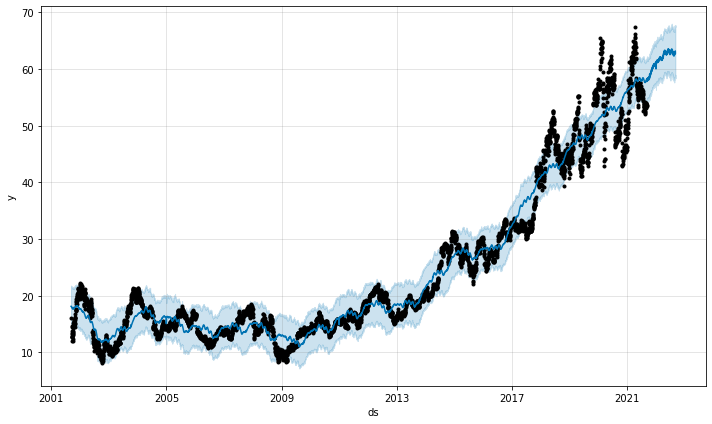

In [21]:
fig_model_plot = model.plot(predict)

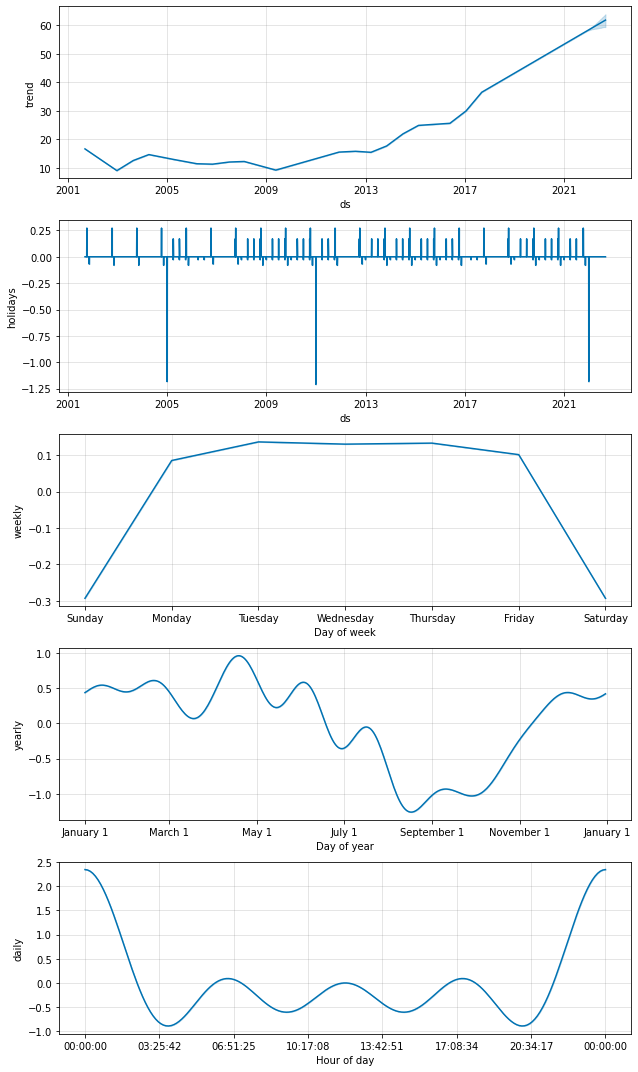

In [22]:
fig_model_plot_components = model.plot_components(predict)

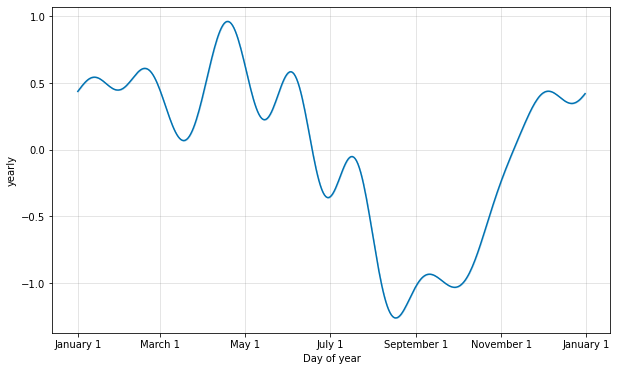

In [23]:
fig_model_plot_yearly = plot_yearly(model)

In [24]:
plot_plotly(model, predict)

In [25]:
plot_components_plotly(model, predict)

# Extra: Log transform

In [26]:
data.tail()

,ds,y
10452,2021-08-30,53.939999
10453,2021-08-31,54.060001
10454,2021-09-01,53.669998
10455,2021-09-02,53.730000
10456,2021-09-03,53.509998


In [27]:
data_log_transform = data

In [28]:
data_log_transform['y'] = np.log(data_log_transform['y'])

In [29]:
data_log_transform.tail()

,ds,y
10452,2021-08-30,3.987872
10453,2021-08-31,3.990095
10454,2021-09-01,3.982854
10455,2021-09-02,3.983971
10456,2021-09-03,3.979869


In [30]:
model_log_transform = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
model_log_transform.add_country_holidays(country_name='US')
model_log_transform.fit(data_log_transform)

In [31]:
future_log_transform = model_log_transform.make_future_dataframe(periods=365)
predict_log_transform = model_log_transform.predict(future_log_transform)

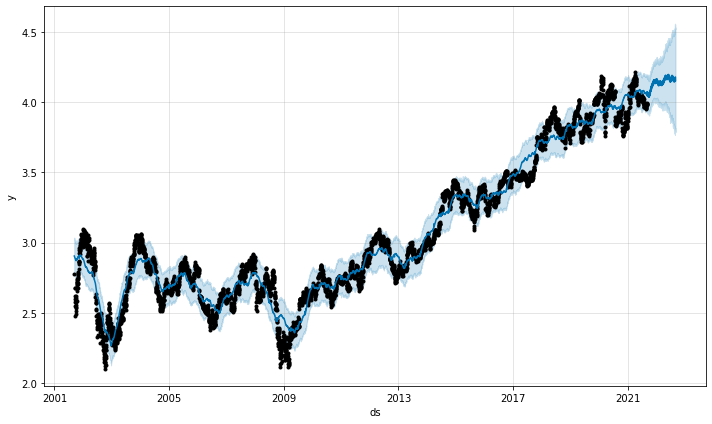

In [32]:
fig_model_log_transform_plot = model_log_transform.plot(predict_log_transform)

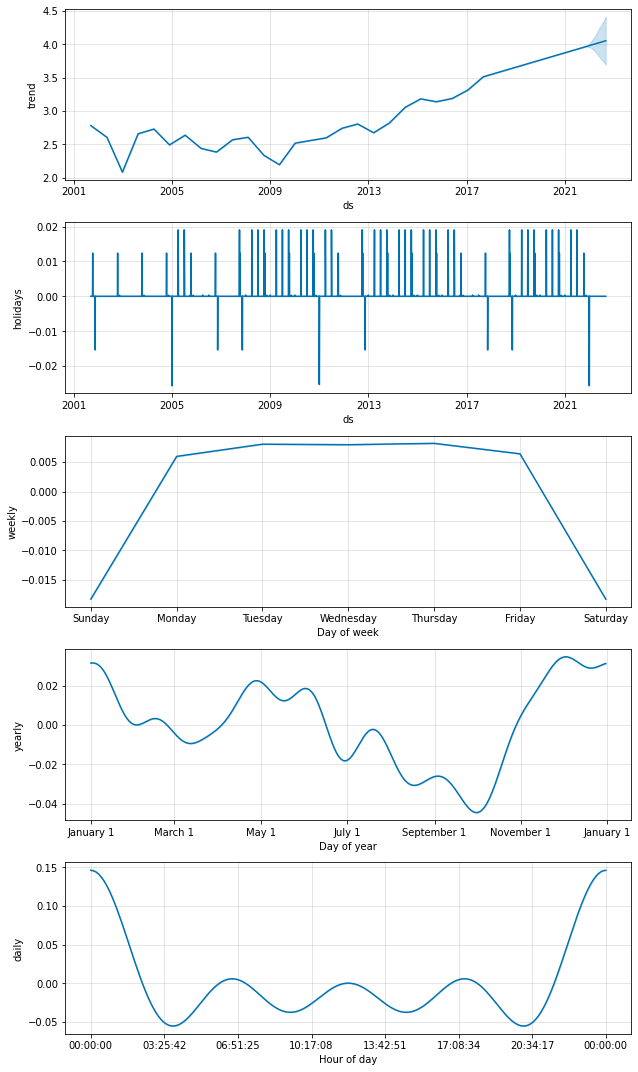

In [33]:
fig_model_log_transform_plot_components = model_log_transform.plot_components(predict_log_transform)

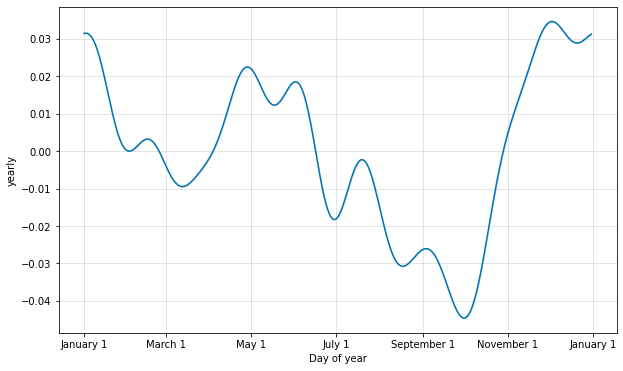

In [34]:
fig_model_log_transform_plot_yearly = plot_yearly(model_log_transform)

In [35]:
plot_plotly(model_log_transform, predict_log_transform)

In [36]:
plot_components_plotly(model_log_transform, predict_log_transform)

Thanks you for your watching. Please let me know your though if any.

Hope you have a great day!